# Hallar la gráfica de potencia vs probabilidad de aparición

- Capturar señales. x
- Clasificar señales entre presencia y no presencia. x
- Estimar psd welch por cada señal por cada tipo. x
- Potencia promedio de cada señal con un ancho de banda del 90% Hacer vector.
- Construir histograma por cada tipo. Usar kde.
- Definir media y varianza por cada tipo.
- Definr umbral como el punto de intersección entre las gaussianas, o si no es el caso, el promedio de la media de cada gaussiana.

In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import librosa
import scipy.signal as sig
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import gaussian_kde

In [4]:
def audio_matrix(path, scaler):
    fs_v = []
    audio_m = []

    for file in os.listdir(path):
        file_path = os.path.join(path, file)
        
        
        y, sr = librosa.load(file_path, sr=None)
        y = librosa.to_mono(y)
        y = y.reshape(-1, 1)
        y = scaler.fit_transform(y)
        y = y.flatten()
        
        fs_v.append(sr)
        audio_m.append(y)

    fs = np.mean(fs_v)

    
    max_length = max(len(y) for y in audio_m)
    audio_m_padded = np.array([np.pad(y, (0, max_length - len(y)), 'constant') for y in audio_m])

    return audio_m_padded, fs

def welch_vector(X, fs, window, nperseg, nfft):
    return sig.welch(X, fs, window=window, nperseg=nperseg, noverlap=(nperseg//2), nfft=nfft)

def psd_matrix(audio_m,  fs, window):
    M = audio_m.shape[0]
    N = audio_m.shape[1]

    psd_matrix = np.zeros((M,N))          
    for i in range(M):
        audio_v = audio_m[i]
        f, psd = welch_vector(audio_v, fs,  window, (N-1), (N*2)-1)
        psd_matrix[i] = psd
    return f, psd_matrix

def audio_classif(classif,  audio_m):
    N = audio_m.shape[1]

    one_count = np.sum(classif)
    zero_count = len(classif) - one_count

    audio_one_m = np.zeros((one_count, N))
    audio_zero_m = np.zeros((zero_count, N))

    audio_one_m = audio_m[classif == 1]
    audio_zero_m = audio_m[classif == 0]

    return  audio_one_m, audio_zero_m

def firwin_filter(signal, lowcut, highcut, numtaps, fs): #Filter FIR

    filter_coeficients = sig.firwin(numtaps, [lowcut, highcut], pass_zero=False, fs=fs)

    return sig.lfilter(filter_coeficients, 1.0, signal)

def audio_filter(audio_m, lowcut, highcut, numtaps, fs):
    M = audio_m.shape[0]
    N = audio_m.shape[1]

    filtered_signal_m = np.zeros((M,N))
    for i in range(M):
        filtered_signal_m[i] = firwin_filter(audio_m[i], lowcut, highcut, numtaps, fs)
    return filtered_signal_m

In [5]:
path = r'C:\Audio_fm'
scaler = MinMaxScaler(feature_range=(-1, 1))
audio_m, fs = audio_matrix(path, scaler)

df = pd.read_excel('audio_fm_classification.xlsx')
df.head()

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Audio_fm'

In [4]:
lowcut = 30
highcut = 15000
numtaps = 301
audio_filt = audio_filter(audio_m, lowcut, highcut, numtaps, fs)

classif = df['Classification'].to_numpy()

audio_ones, audio_zeros = audio_classif(classif, audio_m)

In [5]:
f, psd_ones = psd_matrix(audio_ones, fs,  'blackmanharris')
f, psd_zeros = psd_matrix(audio_zeros, fs,  'blackmanharris')

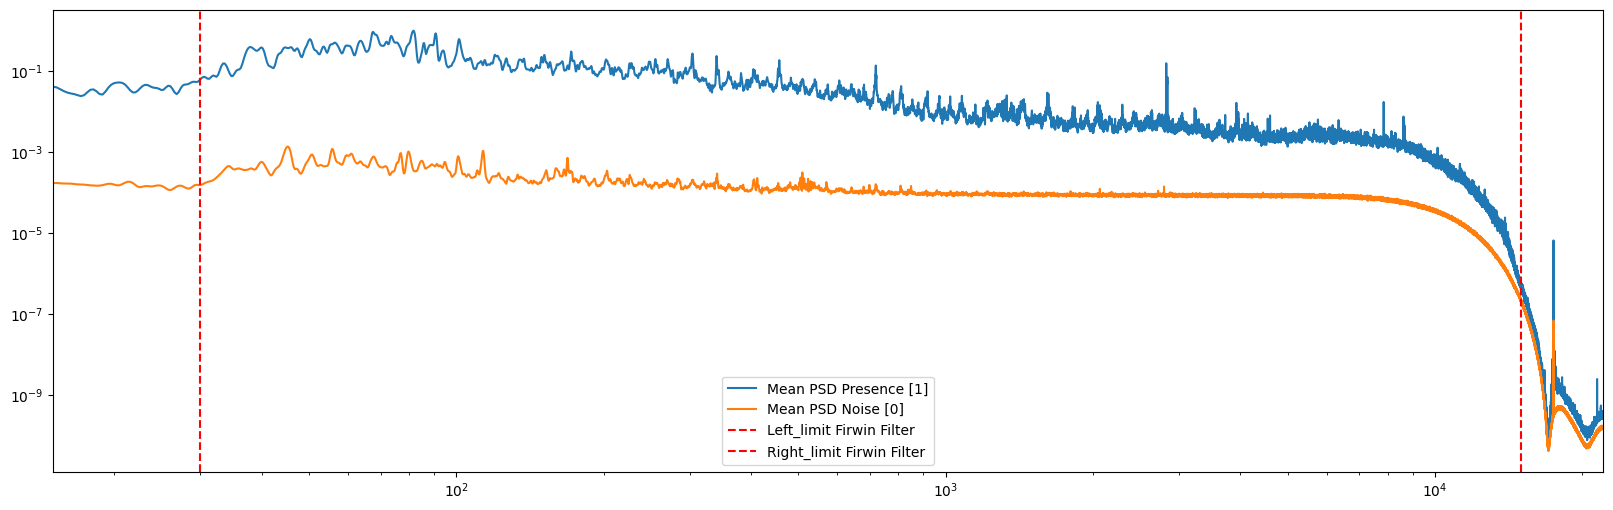

In [6]:
psd_ones_mean = np.mean(psd_ones, axis=0)
psd_zeros_mean = np.mean(psd_zeros, axis=0)

psd_ones_max = np.max(psd_ones_mean)
psd_zeros_max = np.max(psd_zeros_mean)

psd_ones_mean_normalized = psd_ones_mean / psd_ones_max
psd_zeros_mean_normalized = psd_zeros_mean / psd_ones_max



plt.figure(figsize=(20,6))
plt.loglog(f, psd_ones_mean_normalized, label='Mean PSD Presence [1]')
plt.loglog(f, psd_zeros_mean_normalized, label='Mean PSD Noise [0]')
plt.axvline(x=30, color='red', linestyle='--', label='Left_limit Firwin Filter')
plt.axvline(x=15000, color='red', linestyle='--', label='Right_limit Firwin Filter')
plt.xlim(15, np.max(f))
plt.legend()
plt.show()

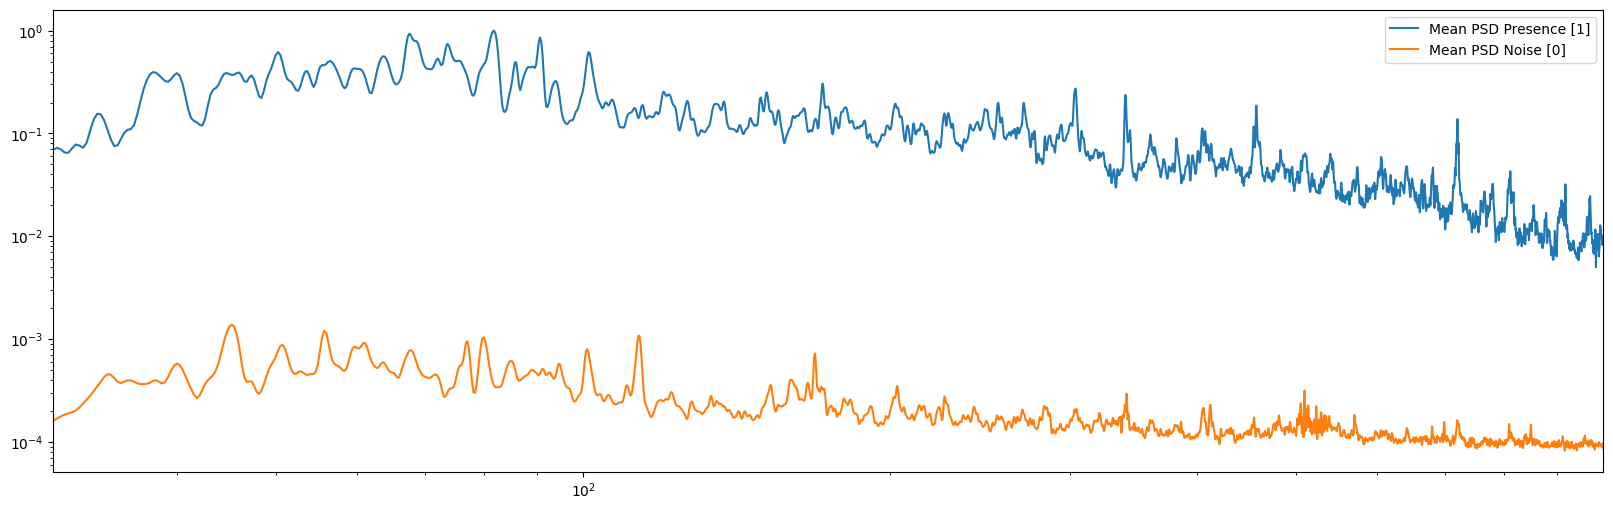

In [7]:
# Ancho de Banda

left_lim = 30
right_lim = 1000

bandwidth = np.where((f >= left_lim) & (f <= right_lim))

bandwidth_f = f[bandwidth]
psd_ones_band = psd_ones[:, bandwidth[0]]
psd_zeros_band = psd_zeros[:, bandwidth[0]]

psd_ones_mean = np.mean(psd_ones_band, axis=0)
psd_zeros_mean = np.mean(psd_zeros_band, axis=0)

psd_ones_max = np.max(psd_ones_mean)
psd_zeros_max = np.max(psd_zeros_mean)

psd_ones_mean_normalized = psd_ones_mean / psd_ones_max
psd_zeros_mean_normalized = psd_zeros_mean / psd_ones_max

plt.figure(figsize=(20,6))
plt.loglog(bandwidth_f, psd_ones_mean_normalized, label='Mean PSD Presence [1]')
plt.loglog(bandwidth_f, psd_zeros_mean_normalized, label='Mean PSD Noise [0]')
plt.xlim(np.min(bandwidth_f), np.max(bandwidth_f))
plt.legend()
plt.show()

In [8]:
psd_ones_power_v = np.zeros((psd_ones_band.shape[0]))
psd_zeros_power_v = np.zeros((psd_zeros_band.shape[0]))

for i in range(psd_ones_band.shape[0]):
    psd_row = psd_ones_band[i]
    psd_row_max = np.max(psd_row)
    psd_ones_power_v[i] = np.mean(psd_row)/psd_row_max

for i in range(psd_zeros_band.shape[0]):
    psd_row = psd_zeros_band[i]
    psd_row_max = np.max(psd_row)
    psd_zeros_power_v[i] = np.mean(psd_row)/psd_row_max

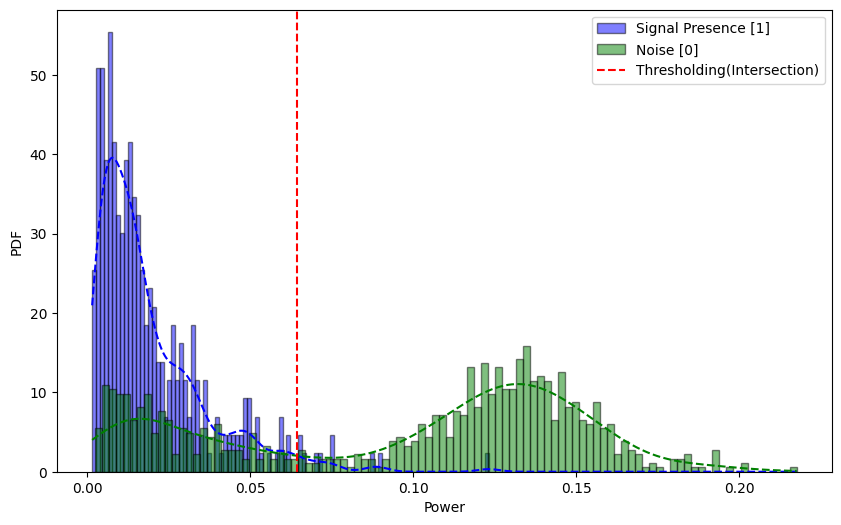

In [9]:
kde_ones = gaussian_kde(psd_ones_power_v, bw_method=0.2)
kde_zeros = gaussian_kde(psd_zeros_power_v, bw_method=0.2)

x = np.linspace(min(psd_zeros_power_v.min(), psd_ones_power_v.min()), 
                max(psd_zeros_power_v.max(), psd_ones_power_v.max()), 1000)

pdf_ones = kde_ones(x)
pdf_zeros = kde_zeros(x)

diff = pdf_ones - pdf_zeros
intersection = np.where(np.diff(np.sign(diff)))[0]
intersection_value = x[intersection][0]

plt.figure(figsize=(10,6))
plt.hist(psd_ones_power_v, bins=100, density=True, alpha=0.5, color='blue', label='Signal Presence [1]', edgecolor='black')
plt.hist(psd_zeros_power_v, bins=100, density=True, alpha=0.5, color='green', label='Noise [0]', edgecolor='black')
plt.plot(x, pdf_ones, 'b--')
plt.plot(x, pdf_zeros, 'g--')
plt.axvline(x=intersection_value, color='red', linestyle='--', label='Thresholding(Intersection)')
plt.xlabel('Power')
plt.ylabel('PDF')
plt.legend()
plt.show()